In [0]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import string
import numpy as np
from numpy import array
import glob
from sklearn.model_selection import train_test_split
from keras.preprocessing import image
from PIL import Image
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.models import Model
from pickle import dump, load
from time import time
import pickle
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras import Input, layers
from keras import optimizers
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import json
!pip install -q gpt_2_simple
import gpt_2_simple as gpt2
from datetime import datetime
from google.colab import files

Using TensorFlow backend.


     |████████████████████████████████| 645kB 9.6MB/s 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [0]:
from google.colab import files

In [0]:
gpt2.download_gpt2(model_name='345M' )

Fetching checkpoint: 1.05Mit [00:00, 509Mit/s]                                                      
Fetching encoder.json: 1.05Mit [00:00, 82.1Mit/s]                                                   
Fetching hparams.json: 1.05Mit [00:00, 344Mit/s]                                                    
Fetching model.ckpt.data-00000-of-00001: 1.42Git [00:11, 123Mit/s]                                  
Fetching model.ckpt.index: 1.05Mit [00:00, 253Mit/s]                                                
Fetching model.ckpt.meta: 1.05Mit [00:00, 84.9Mit/s]                                                
Fetching vocab.bpe: 1.05Mit [00:00, 131Mit/s]                                                       


In [0]:
gpt2.copy_checkpoint_from_gdrive(run_name='run1')

In [0]:
sess = gpt2.start_tf_sess()
gpt2.load_gpt2(sess, run_name='run1')

Loading checkpoint checkpoint/run1/model-3500
INFO:tensorflow:Restoring parameters from checkpoint/run1/model-3500


In [0]:
def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299)) # Convert all the images to size 299x299 as expected by the inception v3 model
    x = image.img_to_array(img) # Convert PIL image to numpy array of 3-dimensions
    x = np.expand_dims(x, axis=0) # Add one more dimension
    x = preprocess_input(x) # preprocess the images using preprocess_input() from inception module
    return x

In [0]:
model = InceptionV3(weights= 'imagenet') # Load the inception v3 model
model_new = Model(model.input, model.layers[-2].output) # Create a new model, by removing the last layer (output layer) from the inception v3














96116736/96112376 [==============================] - 3s 0us/step


In [0]:
def encode(image): # Function to encode a given image into a vector of size (2048, )
    image = preprocess(image) # preprocess the image
    fea_vec = model_new.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

In [0]:
with open('/content/drive/My Drive/Project minor/project/data.json', 'r') as f:
    wordtoix = json.load(f)


In [0]:
ixtoword = {v: k for k, v in wordtoix.items()}
vocab_size = len(ixtoword.keys()) +1
max_length = 74

In [0]:
#load glove vetors
embeddings_index = {} # empty dictionary
f = open('/content/drive/My Drive/Project minor/project/glove.6B.200d.txt', encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [0]:
embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [0]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [0]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0

In [0]:
model.load_weights('/content/drive/My Drive/Project minor/project/model_30.h5')

In [0]:
def textSearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [0]:
def captioning(path_image):
    image = encode(path_image)
    img = plt.imread(path_image)
    plt.imshow(img)
    x = image.reshape((1,2048))
    return textSearch(x)

In [0]:
def story_generator(path):
    text = captioning(path)
    return gpt2.generate(sess,
              length=500,
              temperature=0.9,
              prefix=text,
              nsamples=1,
              batch_size=1,
              top_k=20,
              include_prefix=True,
              ) 

group of people are walking down the street, and
the one who has the strongest desire to do a good deed is walking in the
same direction  But when he gets to the house, where the people are
all sitting on a large bed, he gets into a good temper, and is angry,
and goes away 
A man of letters, whom I have known for some time, has a house near
Bremen, and when he has taken his breakfast, he puts it in a box
with a heavy lid and closes it up, so as to be hidden from the
people of his neighbourhood  One day, the door is opened, and he sees
that the lid is not locked in  'Well, who could I be doing here? It is
very late, and I must go away, so I must go out ' He went out of
his house, walked for one hundred paces along the road, then stopped,
and said to himself: 'I don't know how I could live like this so long '
So he took out his watch and went out of doors, and on a certain day
or other he stopped and went to the nearest church, and he sat down to
the pew  A certain person came in with a 

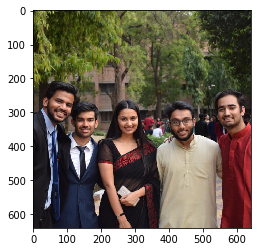

In [0]:
story_generator('/content/drive/My Drive/Project minor/project/pp (1).jpeg')

group of people are riding bicycles in the street and there's some kind of a car and a bicycle"
"Yes," said the youth, "but that's all that I want, because I can't see
them, because they're so far away " They said this, and the youth
continued: "That's the reason I come at midnight at night, so as to be
in a hurry to see them  I don't mind being late if it's only for
two or three hours, but now I should like to go and see them  They'll
all be in their sleep  And I'll tell him all about the new house  Then we
can all go and live together; and so he'll have something to do  And if
there's anything wrong, I'll tell him about it  If there's no problem,
he can do something about it himself  And when everything is all settled
I'll give him my word, too, if he does his best  The old man says,"
"What old man?"
"You see, you don't know anything  Now you see, I'm quite clever, and
I'll write this letter with great cunning  I won't tell any one what
I am, except that I know him; and then I'll let

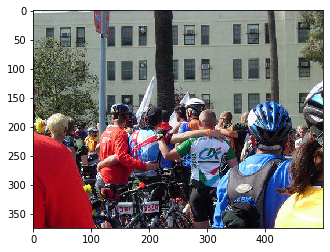

In [0]:
story_generator('/content/drive/My Drive/Project minor/project/19469520.jpg')

group of people are walking down the street in the afternoon
in a group   The one is holding the umbrella, the other carries a
towel   The one is smiling   It is a smiling face 
      He is not a smiling face       He is a lying face 
        He is the face of death         He is the face of the dead 
The voice of the narrator is heard to echo:        "He is the face of
death "
The voice then is heard to utter another cry, in which it is
observed that a faint echo has been introduced   The voice is heard
to repeat:                  _   _    
              _                                                                     
The voice of the narrator has said, "A voice that whispers a
sorrowful word   There is no end to the grief which this face
must bear   It is not a happy face, for its face is not a
joyous face, but it is sad, and that is its beauty   But it is
not all sorrow   You know that I am a writer, and that, as it is
said, 'tis the voice of the pen that writes the history of

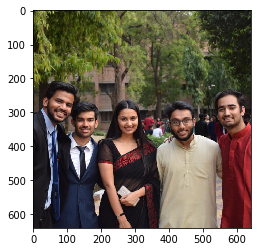

In [0]:
story_generator('/content/drive/My Drive/Project minor/project/pp (1).jpeg')

In [0]:
def uploader():
    uploaded = files.upload()
    pat = '/content/' + str(list(uploaded.keys())[0])
    story_generator(pat)

In [0]:
uploader()

woman in black jacket and sunglasses is sitting on the sidewalk on a hill on the north side of the city, with her head turned westward, and her hand in her coat pocket
toward the sky  And when she was in front of the church, she stopped to take a glance
in the direction of the church, and then she went and sat down in one of the seats
just as you did, and you, too, as she sat down; and then you went out with her 
The other two women took their places on the sidewalk  And when the three of them
came home, they sat down by the window and talked to the children 
One of them said  You see  My mother was always going to be a mother of
some kind  She was just going to do that when she got out, you see  She was going
to have a little girl, and she wanted to have a little boy, and she wanted to
have a little girl and a little boy, and her husband wanted to have no one,
and she wanted to have no one,and she got a little boy, and she wanted to have no
one,and she got a little boy and a little wo

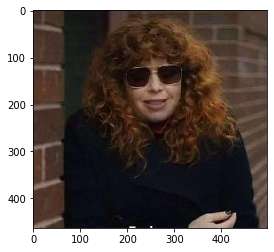

In [0]:
story_generator('/content/drive/My Drive/Project minor/project/f2d9cf66-f15d-417d-9009-afd8f9573bd2.jpeg')